# Artificial Intelligence 

## Project 2: Time Series Forecasting using NN, LSTM and CNN 

### Developed By:
       Vrushank Shah

### Problem Formulation:

Time series forecasting is an important area of AI.  It is important because there are so many prediction problems that involve a time component.  This time component makes time series problems more difficult to handle. In this project, we deal with time series data to predict stock price using fully connected neural netowrk, LSTM and CNN models. 

In [1]:
from collections.abc import Sequence
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def to_sequences(seq_size, data, data1):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data1[i+SEQUENCE_SIZE]
        #window = [[x] for x in window]
       #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

def to_sequences_cnn(seq_size, data1 ,data2):
    x = []
    y = []

    for i in range(len(data1)-SEQUENCE_SIZE-1):
        #print(i)
        window = data1[i:(i+SEQUENCE_SIZE)]
        after_window = data2[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
       #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [2]:
#Read the file
import pandas as pd
data = pd.read_csv(r'C:\Users\16696\Desktop\AI_Project2\CSC215_P2_Stock_Price.csv')

In [3]:
data

,Date,Open,High,Low,Close,Adj_Close,Volume
0,3/27/2000,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,3/28/2000,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,3/29/2000,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,3/30/2000,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,3/31/2000,3.734375,3.734375,3.390625,3.390625,3.390625,7931600
...,...,...,...,...,...,...,...
4387,9/1/2017,113.790001,114.099998,112.790001,113.309998,113.309998,950000
4388,9/5/2017,112.519997,113.529999,111.160004,111.870003,111.870003,1805200
4389,9/6/2017,112.029999,112.489998,110.250000,112.230003,112.230003,2136700
4390,9/7/2017,112.459999,112.900002,112.000000,112.339996,112.339996,1251600


In [4]:
#Drop 'Date' and 'Adj_Close' columns as they are not needed for prediction
data.drop(['Date','Adj_Close'] , axis=1,inplace=True)

In [5]:
data

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600
...,...,...,...,...,...
4387,113.790001,114.099998,112.790001,113.309998,950000
4388,112.519997,113.529999,111.160004,111.870003,1805200
4389,112.029999,112.489998,110.250000,112.230003,2136700
4390,112.459999,112.900002,112.000000,112.339996,1251600


In [6]:
data.head()


,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [7]:
#Check for null values
print(data.isnull().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [8]:
#Select the target feature and convert it to list
data_close = data['Close'].tolist()

In [9]:
data_close

[4.125,
 4.015625,
 4.0,
 3.84375,
 3.390625,
 3.4375,
 3.5,
 3.484375,
 3.578125,
 3.609375,
 3.640625,
 3.578125,
 3.578125,
 3.613275,
 3.609375,
 3.5625,
 3.515625,
 3.59375,
 3.65625,
 3.5625,
 3.765625,
 3.828125,
 3.703125,
 3.75,
 3.6875,
 3.640625,
 3.5625,
 3.6875,
 3.78125,
 3.8125,
 3.75,
 3.796875,
 3.734375,
 3.921875,
 4.09375,
 4.125,
 4.0,
 3.890625,
 3.828125,
 3.890625,
 3.90625,
 4.109375,
 4.328125,
 4.5,
 4.9375,
 5.078125,
 4.96875,
 4.796875,
 4.53125,
 4.28125,
 4.625,
 4.625,
 4.625,
 4.65625,
 4.59375,
 4.609375,
 4.578125,
 4.5,
 4.53125,
 4.453125,
 4.75,
 4.859375,
 4.96875,
 4.96875,
 4.78125,
 5.109375,
 5.0625,
 4.6289,
 5.140625,
 4.921875,
 5.0625,
 5.125,
 5.3125,
 5.5,
 5.53125,
 5.8125,
 5.734375,
 5.703125,
 5.96875,
 6.046875,
 6.015625,
 6.21875,
 6.1875,
 6.125,
 5.984375,
 5.875,
 5.765625,
 5.453125,
 5.65625,
 5.703125,
 5.78125,
 5.75,
 5.65625,
 5.625,
 5.53125,
 5.421875,
 5.609375,
 5.640625,
 5.703125,
 5.71875,
 5.6875,
 5.625,
 5.7968

In [10]:
data_close[0:5]

[4.125, 4.015625, 4.0, 3.84375, 3.390625]

In [11]:
#Feature normalization using z-score normalization 
encode_numeric_zscore(data,"Open")
encode_numeric_zscore(data,"Low")
encode_numeric_zscore(data,"High")
encode_numeric_zscore(data,"Volume")
encode_numeric_zscore(data,"Close")

In [12]:
data[0:5]

,Open,High,Low,Close,Volume
0,-0.894209,-0.885022,-0.892306,-0.884364,1.104812
1,-0.883762,-0.886056,-0.885975,-0.888021,-0.497301
2,-0.887941,-0.889159,-0.887558,-0.888543,-0.892217
3,-0.887941,-0.890194,-0.891251,-0.893768,-0.000263
4,-0.896820,-0.898986,-0.906551,-0.908920,3.729366


In [13]:
#Preparing x and y to process time-series data
SEQUENCE_SIZE = 7
x,y = to_sequences(SEQUENCE_SIZE, data.values, data_close)

print("Shape of x: {}".format(x.shape))
print("Shape of y: {}".format(y.shape))

Shape of x: (4384, 7, 5)
Shape of y: (4384,)


# Full-connected Neural Network 

In [14]:
#Reshaping the input to fit in full-connected neural network i.e. 7 * 5 = 35 input features and 1 output feature. 
x_neural=x.reshape(4384,7*5)
y_neural=y

In [15]:
x_neural.shape

(4384, 35)

In [16]:
y_neural.shape

(4384,)

In [17]:
#Splitting data into training and test data using train_test_split function
x_train,x_test,y_train,y_test = train_test_split(x_neural,y_neural, test_size=0.3, random_state = 0)

In [18]:
x_train.shape

(3068, 35)

In [19]:
x_test.shape

(1316, 35)

In [20]:
y_train.shape

(3068,)

In [21]:
y_test.shape

(1316,)

In [22]:
import os
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [23]:
x_train.astype(np.float32)
x_test.astype(np.float32)

array([[ 0.38250223,  0.3729235 ,  0.37230736, ...,  0.43004686,
         0.4209026 , -0.3504095 ],
       [ 1.4923223 ,  1.4827851 ,  1.4386315 , ...,  1.5978372 ,
         1.6183301 , -0.12483106],
       [-0.6210994 , -0.6258857 , -0.62420595, ..., -0.64919263,
        -0.65113103,  1.9291786 ],
       ...,
       [ 2.5882695 ,  2.5959568 ,  2.606422  , ...,  2.5635395 ,
         2.5509257 , -0.3359794 ],
       [-0.6652248 , -0.6665994 , -0.6629522 , ..., -0.6594912 ,
        -0.66224927, -0.30095246],
       [ 0.39236352,  0.38666025,  0.38868383, ...,  0.3662295 ,
         0.36221826,  1.9967657 ]], dtype=float32)

## Neural Network with 'relu' as activation function and 'adam' as optimizer

In [24]:
#from tensorflow.keras import optimizers
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_neural_relu_adam.hdf5', verbose=0, save_best_only=True)

model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='relu'))

model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
    
model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

print('Training finished...Loading the best model')  
print()
model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_neural_relu_adam.hdf5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 1s - loss: 1204.9422 - val_loss: 207.3846
Epoch 2/1000
3068/3068 - 0s - loss: 166.4421 - val_loss: 157.2482
Epoch 3/1000
3068/3068 - 1s - loss: 135.3951 - val_loss: 123.9836
Epoch 4/1000
3068/3068 - 0s - loss: 96.9421 - val_loss: 81.3796
Epoch 5/1000
3068/3068 - 0s - loss: 54.8403 - val_loss: 41.9409
Epoch 6/1000
3068/3068 - 0s - loss: 24.3859 - val_loss: 17.9012
Epoch 7/1000
3068/3068 - 0s - loss: 10.5590 - val_loss: 9.3568
Epoch 8/1000
3068/3068 - 0s - loss: 5.4613 - val_loss: 5.9105
Epoch 9/1000
3068/3068 - 1s - loss: 3.3740 - val_loss: 4.4448
Epoch 10/1000
3068/3068 - 0s - loss: 2.3904 - val_loss: 3.7608
Epoch 11/1000
3068/3068 - 0s - loss: 1.7194 - val_loss: 2.9206
Epoch 12/1000
3068/3068 - 0s - loss: 1.4528 - val_loss: 2.7762
Epoch 13/1000
3068/3068 - 0s - loss: 1.3455 - val_loss: 2.6724
Epoch 14/1000
3068/3068 - 0s - loss: 1.27

In [25]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_neural_relu_adam.hdf5')
neural_pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(y_test,neural_pred)) 

print("RMSE : {}".format(score))

RMSE : 1.2709944547608023


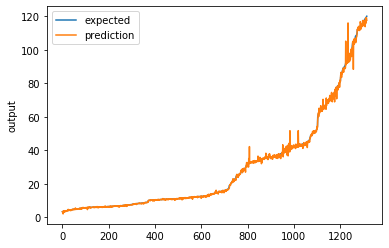

In [26]:
chart_regression(neural_pred.flatten(),y_test)

## Neural Network with 'tanh' as activation function and 'adam' as optimizer

In [27]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_neural_tanh_adam.hdf5', verbose=0, save_best_only=True)

model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='tanh'))
model.add(Dense(32,activation='tanh'))
model.add(Dense(1,activation='tanh'))

model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
    
model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

print('Training finished...Loading the best model')  
print()
model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_neural_tanh_adam.hdf5')

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 1s - loss: 1816.2670 - val_loss: 1741.6512
Epoch 2/1000
3068/3068 - 0s - loss: 1792.4119 - val_loss: 1723.4015
Epoch 3/1000
3068/3068 - 0s - loss: 1789.0298 - val_loss: 1723.1464
Epoch 4/1000
3068/3068 - 0s - loss: 1788.8956 - val_loss: 1723.0789
Epoch 5/1000
3068/3068 - 0s - loss: 1788.8497 - val_loss: 1723.0495
Epoch 6/1000
3068/3068 - 0s - loss: 1788.8275 - val_loss: 1723.0335
Epoch 7/1000
3068/3068 - 0s - loss: 1788.8149 - val_loss: 1723.0238
Epoch 8/1000
3068/3068 - 0s - loss: 1788.8069 - val_loss: 1723.0175
Epoch 9/1000
3068/3068 - 0s - loss: 1788.8016 - val_loss: 1723.0131
Epoch 10/1000
3068/3068 - 0s - loss: 1788.7977 - val_loss: 1723.0099
Epoch 11/1000
3068/3068 - 0s - loss: 1788.7949 - val_loss: 1723.0074
Epoch 12/1000
3068/3068 - 0s - loss: 1788.7928 - val_loss: 1723.0056
Epoch 13/1000
3068/3068 - 0s - loss: 1788.7911 - val_loss: 1723.0041
Epoch 14/1000
3068/3068 - 0s - loss: 1788.7898 - val_loss: 1723.

In [28]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_neural_tanh_adam.hdf5')
neural_pred = model.predict(x_test)

score1 = np.sqrt(metrics.mean_squared_error(y_test,neural_pred)) 

print("RMSE : {}".format(score1))

RMSE : 41.50898095071036


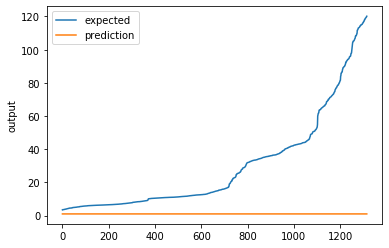

In [29]:
chart_regression(neural_pred.flatten(),y_test)

## Neural Network with 'sigmoid' as activation function and 'adam' as optimizer 

In [30]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_neural_sigmoid_adam.hdf5', verbose=0, save_best_only=True)

model = Sequential()
model.add(Dense(100, input_dim=x_train.shape[1], activation='sigmoid'))
model.add(Dense(50,activation='sigmoid'))
model.add(Dense(50,activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
    
model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

print('Training finished...Loading the best model')  
print()
model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_neural_sigmoid_adam.hdf5')

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 1s - loss: 1795.6341 - val_loss: 1723.8819
Epoch 2/1000
3068/3068 - 1s - loss: 1789.3803 - val_loss: 1723.3944
Epoch 3/1000
3068/3068 - 1s - loss: 1789.1032 - val_loss: 1723.2434
Epoch 4/1000
3068/3068 - 1s - loss: 1788.9944 - val_loss: 1723.1692
Epoch 5/1000
3068/3068 - 1s - loss: 1788.9359 - val_loss: 1723.1257
Epoch 6/1000
3068/3068 - 1s - loss: 1788.8999 - val_loss: 1723.0974
Epoch 7/1000
3068/3068 - 1s - loss: 1788.8757 - val_loss: 1723.0778
Epoch 8/1000
3068/3068 - 1s - loss: 1788.8585 - val_loss: 1723.0635
Epoch 9/1000
3068/3068 - 1s - loss: 1788.8458 - val_loss: 1723.0528
Epoch 10/1000
3068/3068 - 1s - loss: 1788.8361 - val_loss: 1723.0445
Epoch 11/1000
3068/3068 - 1s - loss: 1788.8285 - val_loss: 1723.0380
Epoch 12/1000
3068/3068 - 1s - loss: 1788.8225 - val_loss: 1723.0326
Epoch 13/1000
3068/3068 - 1s - loss: 1788.8175 - val_loss: 1723.0282
Epoch 14/1000
3068/3068 - 1s - loss: 1788.8134 - val_loss: 1723.

In [31]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_neural_sigmoid_adam.hdf5')
neural_pred = model.predict(x_test)

score2 = np.sqrt(metrics.mean_squared_error(y_test,neural_pred)) 

print("RMSE : {}".format(score2))

RMSE : 41.50898325998571


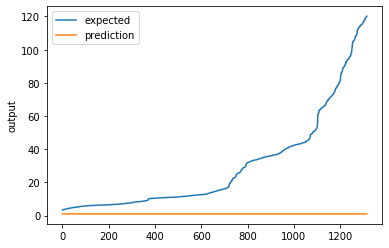

In [32]:
chart_regression(neural_pred.flatten(),y_test)

## Neural Network with 'relu' as activation function and 'sgd' as optimizer

In [33]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_neural_relu_sgd.hdf5', verbose=0, save_best_only=True)

model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='relu'))

#sgd=optimizers.SGD(lr=0.01 , decay=0.0 , clipvalue=0.5, clipnorm=1.)
model.compile(loss='mean_squared_error', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
    
model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

print('Training finished...Loading the best model')  
print()
model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_neural_relu_sgd.hdf5')

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 1s - loss: 53722.2465 - val_loss: 1782.1756
Epoch 2/1000
3068/3068 - 0s - loss: 1849.4091 - val_loss: 1782.1756
Epoch 3/1000
3068/3068 - 0s - loss: 1849.4091 - val_loss: 1782.1756
Epoch 4/1000
3068/3068 - 0s - loss: 1849.4091 - val_loss: 1782.1756
Epoch 5/1000
3068/3068 - 0s - loss: 1849.4091 - val_loss: 1782.1756
Epoch 6/1000
3068/3068 - 0s - loss: 1849.4091 - val_loss: 1782.1756
Epoch 00006: early stopping
Training finished...Loading the best model



In [34]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_neural_relu_sgd.hdf5')
neural_pred = model.predict(x_test)

score3 = np.sqrt(metrics.mean_squared_error(y_test,neural_pred)) 

print("RMSE : {}".format(score3))

RMSE : 42.21582163582829


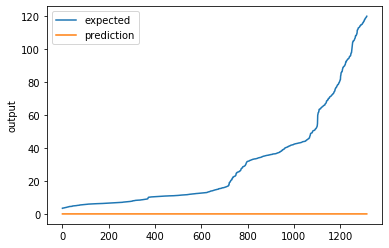

In [35]:
chart_regression(neural_pred.flatten(),y_test)

In [36]:
print("RMSE SCORE:")
print("1)Activation-Relu, Opt-Adam:        {}".format(score))
print("2)Activation-tanh, Opt-adam:        {}".format(score1))
print("3)Activation-sigmoid, Opt-Adam:     {}".format(score2))
print("4)Activation-relu, Opt-sgd:         {}".format(score3))

RMSE SCORE:
1)Activation-Relu, Opt-Adam:        1.2709944547608023
2)Activation-tanh, Opt-adam:        41.50898095071036
3)Activation-sigmoid, Opt-Adam:     41.50898325998571
4)Activation-relu, Opt-sgd:         42.21582163582829


In [37]:
print("Best Fully Connected Neural Network Model is with Activtion- Relu  Opt- Adam and has RMSE score: {}".format(score) )

Best Fully Connected Neural Network Model is with Activtion- Relu  Opt- Adam and has RMSE score: 1.2709944547608023


# LSTM

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding ,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

In [39]:
#Splitting the data into training and test data for LSTM model where each record can be viewed as a sequence of 7 vectors, each vector with 5 dimensions. 
x_train_for_lstm,x_test_for_lstm,y_train_for_lstm,y_test_for_lstm = train_test_split(x,y, test_size=0.3, random_state =0)
print("Shape of x_train: {}".format(x_train_for_lstm.shape))
print("Shape of x_test: {}".format(x_test_for_lstm.shape))
print("Shape of y_train: {}".format(y_train_for_lstm.shape))
print("Shape of y_test: {}".format(y_test_for_lstm.shape))

Shape of x_train: (3068, 7, 5)
Shape of x_test: (1316, 7, 5)
Shape of y_train: (3068,)
Shape of y_test: (1316,)


## LSTM with 'relu' as activation function and 'adam' as optimizer

In [40]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_relu_adam.hdf5', verbose=0, save_best_only=True) # save best model    
print('Build model...')
model = Sequential()
model.add(LSTM(68, activation='relu',dropout=0.0, recurrent_dropout=0.0,input_shape=(7, 5)))
model.add(Dense(34 , activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train_for_lstm,y_train_for_lstm,validation_data=(x_test_for_lstm,y_test_for_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 

Build model...
Train...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 9s - loss: 787.5635 - val_loss: 40.9397
Epoch 2/1000
3068/3068 - 5s - loss: 13.8809 - val_loss: 9.3405
Epoch 3/1000
3068/3068 - 7s - loss: 5.6623 - val_loss: 6.4417
Epoch 4/1000
3068/3068 - 6s - loss: 4.6172 - val_loss: 4.2058
Epoch 5/1000
3068/3068 - 6s - loss: 3.8087 - val_loss: 3.8781
Epoch 6/1000
3068/3068 - 5s - loss: 3.3585 - val_loss: 3.7097
Epoch 7/1000
3068/3068 - 5s - loss: 3.1933 - val_loss: 5.0027
Epoch 8/1000
3068/3068 - 4s - loss: 3.0118 - val_loss: 5.2591
Epoch 9/1000
3068/3068 - 5s - loss: 3.5907 - val_loss: 4.8630
Epoch 10/1000
3068/3068 - 5s - loss: 2.7922 - val_loss: 3.2901
Epoch 11/1000
3068/3068 - 6s - loss: 4.7243 - val_loss: 6.2846
Epoch 12/1000
3068/3068 - 7s - loss: 2.8699 - val_loss: 3.7259
Epoch 13/1000
3068/3068 - 6s - loss: 2.9349 - val_loss: 3.3692
Epoch 14/1000
3068/3

In [41]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_relu_adam.hdf5')
lstm_pred = model.predict(x_test_for_lstm)

score = np.sqrt(metrics.mean_squared_error(y_test_for_lstm,lstm_pred)) 

print("RMSE: {}".format(score))

RMSE: 1.8138515895168938


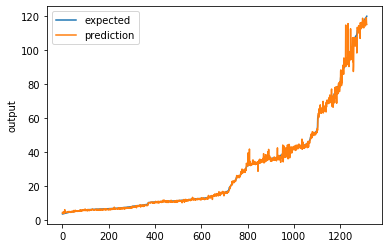

In [42]:
chart_regression(lstm_pred.flatten(),y_test_for_lstm)

## LSTM with 'tanh', 'sigmoid' as activation function and 'adam' as optimizer

In [43]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_tanh_sigmoid_adam.hdf5', verbose=0, save_best_only=True) # save best model    
print('Build model...')
model = Sequential()
model.add(LSTM(68, activation='tanh',dropout=0.0, recurrent_dropout=0.0,input_shape=(7, 5)))
model.add(Dense(34 , activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train_for_lstm,y_train_for_lstm,validation_data=(x_test_for_lstm,y_test_for_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 

Build model...
Train...
Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 7s - loss: 1796.2444 - val_loss: 1723.0785
Epoch 2/1000
3068/3068 - 5s - loss: 1788.8390 - val_loss: 1723.0367
Epoch 3/1000
3068/3068 - 5s - loss: 1788.8161 - val_loss: 1723.0231
Epoch 4/1000
3068/3068 - 4s - loss: 1788.8058 - val_loss: 1723.0155
Epoch 5/1000
3068/3068 - 4s - loss: 1788.7997 - val_loss: 1723.0108
Epoch 6/1000
3068/3068 - 4s - loss: 1788.7957 - val_loss: 1723.0076
Epoch 7/1000
3068/3068 - 4s - loss: 1788.7930 - val_loss: 1723.0054
Epoch 8/1000
3068/3068 - 5s - loss: 1788.7910 - val_loss: 1723.0036
Epoch 9/1000
3068/3068 - 4s - loss: 1788.7894 - val_loss: 1723.0024
Epoch 10/1000
3068/3068 - 4s - loss: 1788.7883 - val_loss: 1723.0013
Epoch 11/1000
3068/3068 - 4s - loss: 1788.7873 - val_loss: 1723.0006
Epoch 12/1000
3068/3068 - 4s - loss: 1788.7866 - val_loss: 1722.9999
Epoch 13/1000
3068/3068 - 4s - loss: 1788.7860 - val_loss: 1722.9993
Epoch 14/1000
3068/3068 - 5s - loss: 178

In [44]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_tanh_sigmoid_adam.hdf5')
lstm_pred = model.predict(x_test_for_lstm)

score1 = np.sqrt(metrics.mean_squared_error(y_test_for_lstm,lstm_pred)) 

print("RMSE: {}".format(score1))

RMSE: 41.50899520635924


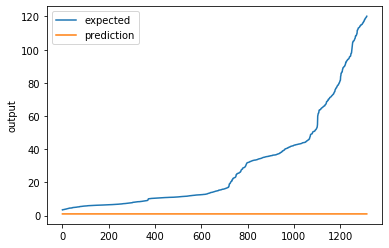

In [45]:
chart_regression(lstm_pred.flatten(),y_test_for_lstm)

## LSTM with 'tanh' as activation function and 'sgd' as optimizer 

In [46]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_tanh_sgd.hdf5', verbose=0, save_best_only=True) # save best model    
print('Build model...')
model = Sequential()
model.add(LSTM(68, activation='tanh',dropout=0.0, recurrent_dropout=0.0,input_shape=(7, 5)))
model.add(Dense(34 , activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train_for_lstm,y_train_for_lstm,validation_data=(x_test_for_lstm,y_test_for_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 

Build model...
Train...
Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 9s - loss: 173.2788 - val_loss: 18.3132
Epoch 2/1000
3068/3068 - 7s - loss: 9.6082 - val_loss: 5.0385
Epoch 3/1000
3068/3068 - 7s - loss: 3.2102 - val_loss: 1.7145
Epoch 4/1000
3068/3068 - 6s - loss: 2.9011 - val_loss: 1.8378
Epoch 5/1000
3068/3068 - 4s - loss: 2.3974 - val_loss: 1.6110
Epoch 6/1000
3068/3068 - 5s - loss: 1.1809 - val_loss: 1.8097
Epoch 7/1000
3068/3068 - 5s - loss: 1.1510 - val_loss: 1.3081
Epoch 8/1000
3068/3068 - 5s - loss: 1.3993 - val_loss: 2.1041
Epoch 9/1000
3068/3068 - 5s - loss: 1.2760 - val_loss: 1.2605
Epoch 10/1000
3068/3068 - 5s - loss: 1.0786 - val_loss: 1.2843
Epoch 11/1000
3068/3068 - 5s - loss: 1.1032 - val_loss: 1.3917
Epoch 12/1000
3068/3068 - 4s - loss: 1.0142 - val_loss: 1.2277
Epoch 13/1000
3068/3068 - 5s - loss: 1.1420 - val_loss: 1.3036
Epoch 14/1000
3068/3068 - 5s - loss: 0.9495 - val_loss: 1.2258
Epoch 15/1000
3068/3068 - 4s - loss: 0.8927 - val_lo

In [47]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_tanh_sgd.hdf5')
lstm_pred = model.predict(x_test_for_lstm)

score2 = np.sqrt(metrics.mean_squared_error(y_test_for_lstm,lstm_pred)) 

print("RMSE: {}".format(score2))

RMSE: 1.065461018699373


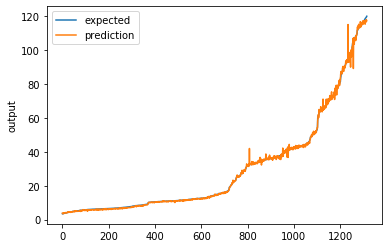

In [48]:
chart_regression(lstm_pred.flatten(),y_test_for_lstm)

## LSTM with 'sigmoid' as activation function and 'sgd' as optimizer

In [49]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_sigmoid_sgd.hdf5', verbose=0, save_best_only=True) # save best model    
print('Build model...')
model = Sequential()
model.add(LSTM(68, activation='sigmoid',dropout=0.0, recurrent_dropout=0.0,input_shape=(7, 5)))
model.add(Dense(34 , activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train_for_lstm,y_train_for_lstm,validation_data=(x_test_for_lstm,y_test_for_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 

Build model...
Train...
Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 7s - loss: 211.1181 - val_loss: 17.3344
Epoch 2/1000
3068/3068 - 5s - loss: 14.1422 - val_loss: 6.1319
Epoch 3/1000
3068/3068 - 5s - loss: 8.0719 - val_loss: 3.6390
Epoch 4/1000
3068/3068 - 5s - loss: 6.0139 - val_loss: 11.9585
Epoch 5/1000
3068/3068 - 4s - loss: 3.4165 - val_loss: 2.2438
Epoch 6/1000
3068/3068 - 4s - loss: 3.5303 - val_loss: 1.6665
Epoch 7/1000
3068/3068 - 4s - loss: 1.8871 - val_loss: 3.5261
Epoch 8/1000
3068/3068 - 4s - loss: 3.3791 - val_loss: 13.5675
Epoch 9/1000
3068/3068 - 4s - loss: 2.2103 - val_loss: 59.7975
Epoch 10/1000
3068/3068 - 6s - loss: 3.3037 - val_loss: 2.9252
Epoch 11/1000
3068/3068 - 4s - loss: 1.7215 - val_loss: 1.2958
Epoch 12/1000
3068/3068 - 4s - loss: 1.4025 - val_loss: 1.9914
Epoch 13/1000
3068/3068 - 4s - loss: 1.6559 - val_loss: 1.7965
Epoch 14/1000
3068/3068 - 7s - loss: 1.1474 - val_loss: 1.1935
Epoch 15/1000
3068/3068 - 7s - loss: 1.4235 - va

In [50]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_sigmoid_sgd.hdf5')
lstm_pred = model.predict(x_test_for_lstm)

score3 = np.sqrt(metrics.mean_squared_error(y_test_for_lstm,lstm_pred)) 

print("RMSE: {}".format(score3))

RMSE: 1.0924637583238457


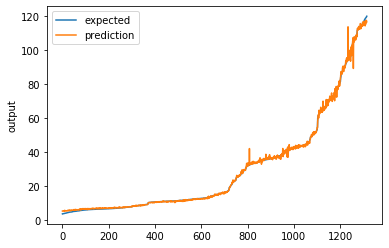

In [51]:
chart_regression(lstm_pred.flatten(),y_test_for_lstm)

## LSTM with 'tanh' as activation function and 'sgd' as optimizer with varied number of LSTM layers and neuron count in each layer

In [55]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_tanh_sgd_varied.hdf5', verbose=0, save_best_only=True) # save best model    
print('Build model...')
model = Sequential()
model.add(LSTM(100,return_sequences=True, activation='tanh', dropout=0.0, recurrent_dropout=0.0,input_shape=(7, 5)))
model.add(LSTM(80, activation='tanh' , input_shape=(7, 5)))
model.add(Dense(50 , activation='tanh'))
model.add(Dense(50, activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train_for_lstm,y_train_for_lstm,validation_data=(x_test_for_lstm,y_test_for_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 

Build model...
Train...
Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 17s - loss: 407.6414 - val_loss: 74.9130
Epoch 2/1000
3068/3068 - 9s - loss: 92.1649 - val_loss: 78.0412
Epoch 3/1000
3068/3068 - 7s - loss: 53.4186 - val_loss: 24.3547
Epoch 4/1000
3068/3068 - 9s - loss: 17.8394 - val_loss: 14.2290
Epoch 5/1000
3068/3068 - 8s - loss: 10.4936 - val_loss: 4.4993
Epoch 6/1000
3068/3068 - 9s - loss: 17.1826 - val_loss: 7.6618
Epoch 7/1000
3068/3068 - 10s - loss: 10.2289 - val_loss: 6.8171
Epoch 8/1000
3068/3068 - 12s - loss: 4.7062 - val_loss: 3.3723
Epoch 9/1000
3068/3068 - 9s - loss: 4.1852 - val_loss: 3.9391
Epoch 10/1000
3068/3068 - 9s - loss: 3.0987 - val_loss: 4.3625
Epoch 11/1000
3068/3068 - 9s - loss: 3.4914 - val_loss: 3.0076
Epoch 12/1000
3068/3068 - 9s - loss: 2.4906 - val_loss: 2.5062
Epoch 13/1000
3068/3068 - 7s - loss: 2.4726 - val_loss: 6.9020
Epoch 14/1000
3068/3068 - 8s - loss: 3.0746 - val_loss: 2.9787
Epoch 15/1000
3068/3068 - 7s - loss: 1.8

In [56]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_tanh_sgd_varied.hdf5')
lstm_pred = model.predict(x_test_for_lstm)

score4 = np.sqrt(metrics.mean_squared_error(y_test_for_lstm,lstm_pred)) 

print("RMSE: {}".format(score4))

RMSE: 1.220066472248339


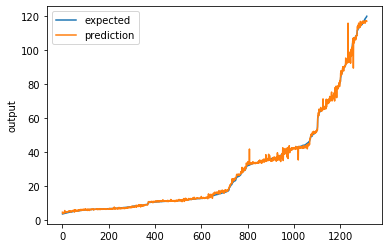

In [57]:
chart_regression(lstm_pred.flatten(),y_test_for_lstm)

In [58]:
print("RMSE SCORE:")
print("1)Activation-Relu, Opt-Adam:        {}".format(score))
print("2)Activation-tanh,sigmoid, Opt-adam: {}".format(score1))
print("3)Activation-tanh, Opt-sgd:         {}".format(score2))
print("4)Activation-sigmoid, Opt-sgd:      {}".format(score3))
print("5)Activation-tanh, Opt-sgd, varied number of LSTM layers and neuron count in each layer: {}".format(score4))

RMSE SCORE:
1)Activation-Relu, Opt-Adam:        1.8138515895168938
2)Activation-tanh,sigmoid, Opt-adam: 41.50899520635924
3)Activation-tanh, Opt-sgd:         1.065461018699373
4)Activation-sigmoid, Opt-sgd:      1.0924637583238457
5)Activation-tanh, Opt-sgd, varied number of LSTM layers and neuron count in each layer: 1.220066472248339


In [59]:
print("Best LSTM model is with Activtion- tanh  Opt- sgd and has RMSE score: {}".format(score2) )

Best LSTM model is with Activtion- tanh  Opt- sgd and has RMSE score: 1.065461018699373


# CNN


In [163]:
#Preparing x and y to process time-series data
SEQUENCE_SIZE = 7
x_cnn,y_cnn = to_sequences_cnn(SEQUENCE_SIZE, data.values, data_close)

print("Shape of x: {}".format(x_cnn.shape))
print("Shape of y: {}".format(y_cnn.shape))

Shape of x: (4384, 7, 1, 5)
Shape of y: (4384,)


In [164]:
x_cnn = x.reshape(4384,1,7,5)
y_cnn = y

In [165]:
x_cnn.shape

(4384, 1, 7, 5)

In [166]:
y_cnn.shape

(4384,)

In [167]:
#Splitting data into training and test data where the cell can be viewed as an image that has 7 pixels, each pixel with 5 channels.
x_train_for_cnn,x_test_for_cnn,y_train_for_cnn,y_test_for_cnn = train_test_split(x_cnn,y_cnn, test_size=0.3, random_state = 0)
print("Shape of x_train: {}".format(x_train_for_cnn.shape))
print("Shape of x_test: {}".format(x_test_for_cnn.shape))
print("Shape of y_train: {}".format(y_train_for_cnn.shape))
print("Shape of y_test: {}".format(y_test_for_cnn.shape))

Shape of x_train: (3068, 1, 7, 5)
Shape of x_test: (1316, 1, 7, 5)
Shape of y_train: (3068,)
Shape of y_test: (1316,)


In [168]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

## CNN with 'relu' as activation function and 'adam' as optimizer

In [66]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),activation='relu',input_shape=(1,7,5),padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1),activation='relu',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Conv2D(128,kernel_size=(3, 3), strides=(1, 1),activation='relu',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Conv2D(256,kernel_size=(3, 3), strides=(1, 1),activation='relu',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(500, activation='relu'))
cnn_model.add(Dropout(0.20))
cnn_model.add(Dense(1))
cnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 7, 32)          1472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 4, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 2, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 256)       

In [1]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_cnn_1.hdf5', verbose=0, save_best_only=True) # save best model
   
cnn_model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
cnn_model.fit(x_train_for_cnn, y_train_for_cnn,batch_size=64,validation_data=(x_test_for_cnn,y_test_for_cnn),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

NameError: name 'ModelCheckpoint' is not defined

In [68]:
from sklearn import metrics

cnn_model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_cnn_1.hdf5')

cnn_model_pred = cnn_model.predict(x_test_for_cnn)

score = np.sqrt(metrics.mean_squared_error(y_test_for_cnn,cnn_model_pred)) 

print("RMSE: {}".format(score))

RMSE: 1.6659472247523361


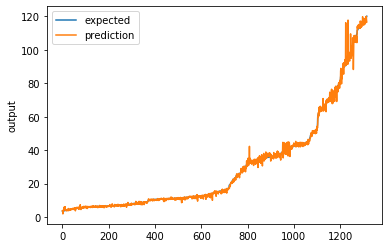

In [69]:
chart_regression(cnn_model_pred.flatten(),y_test_for_cnn)

## CNN with 'sigmoid' as activation function and 'adam' as optimizer

In [70]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),activation='sigmoid',input_shape=(1,7,5),padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1),activation='sigmoid',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Conv2D(128,kernel_size=(3, 3), strides=(1, 1),activation='sigmoid',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Conv2D(256,kernel_size=(3, 3), strides=(1, 1),activation='sigmoid',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(500, activation='sigmoid'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(1))
cnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1, 7, 32)          1472      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 4, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 2, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 1, 256)       

In [71]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_cnn_2.hdf5', verbose=0, save_best_only=True) # save best model
   
cnn_model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
cnn_model.fit(x_train_for_cnn, y_train_for_cnn,batch_size=64,validation_data=(x_test_for_cnn,y_test_for_cnn),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 7s - loss: 1171.1625 - val_loss: 915.1214
Epoch 2/1000
3068/3068 - 2s - loss: 918.8031 - val_loss: 877.1203
Epoch 3/1000
3068/3068 - 2s - loss: 901.1349 - val_loss: 876.9173
Epoch 4/1000
3068/3068 - 2s - loss: 903.0207 - val_loss: 877.4361
Epoch 5/1000
3068/3068 - 2s - loss: 900.5431 - val_loss: 877.7286
Epoch 6/1000
3068/3068 - 2s - loss: 898.9269 - val_loss: 877.4146
Epoch 7/1000
3068/3068 - 2s - loss: 901.7376 - val_loss: 876.9301
Epoch 8/1000
3068/3068 - 2s - loss: 899.5792 - val_loss: 877.4446
Epoch 00008: early stopping


In [72]:
from sklearn import metrics

cnn_model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_cnn_2.hdf5')

cnn_model_pred = cnn_model.predict(x_test_for_cnn)

score1 = np.sqrt(metrics.mean_squared_error(y_test_for_cnn,cnn_model_pred)) 

print("RMSE: {}".format(score1))

RMSE: 29.612789825440313


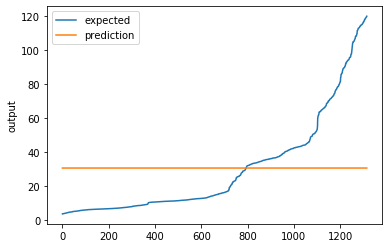

In [73]:
chart_regression(cnn_model_pred.flatten(),y_test_for_cnn)

## CNN with 'tanh' as activation function and 'adam' as optimizer

In [74]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),activation='tanh',input_shape=(1,7,5),padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1),activation='tanh',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Conv2D(128,kernel_size=(3, 3), strides=(1, 1),activation='tanh',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Conv2D(256,kernel_size=(3, 3), strides=(1, 1),activation='tanh',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(500, activation='tanh'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(1))
cnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 1, 7, 32)          1472      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 4, 32)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 2, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 256)       

In [75]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_cnn_3.hdf5', verbose=0, save_best_only=True) # save best model
   
cnn_model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
cnn_model.fit(x_train_for_cnn, y_train_for_cnn,batch_size=64,validation_data=(x_test_for_cnn,y_test_for_cnn),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 7s - loss: 786.1842 - val_loss: 368.3259
Epoch 2/1000
3068/3068 - 2s - loss: 317.1574 - val_loss: 248.5434
Epoch 3/1000
3068/3068 - 2s - loss: 193.5644 - val_loss: 122.0537
Epoch 4/1000
3068/3068 - 2s - loss: 90.7366 - val_loss: 59.5429
Epoch 5/1000
3068/3068 - 2s - loss: 47.4570 - val_loss: 33.0350
Epoch 6/1000
3068/3068 - 2s - loss: 28.7077 - val_loss: 22.0745
Epoch 7/1000
3068/3068 - 2s - loss: 21.8433 - val_loss: 14.7216
Epoch 8/1000
3068/3068 - 2s - loss: 13.6563 - val_loss: 8.7909
Epoch 9/1000
3068/3068 - 2s - loss: 9.8324 - val_loss: 6.4666
Epoch 10/1000
3068/3068 - 2s - loss: 7.3272 - val_loss: 5.4507
Epoch 11/1000
3068/3068 - 2s - loss: 6.0463 - val_loss: 3.8664
Epoch 12/1000
3068/3068 - 2s - loss: 5.2407 - val_loss: 3.5988
Epoch 13/1000
3068/3068 - 2s - loss: 4.9868 - val_loss: 2.8352
Epoch 14/1000
3068/3068 - 2s - loss: 3.6667 - val_loss: 2.6617
Epoch 15/1000
3068/3068 - 2s - loss: 3.4537 - val_loss: 3.

In [76]:
from sklearn import metrics

cnn_model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_cnn_3.hdf5')

cnn_model_pred = cnn_model.predict(x_test_for_cnn)

score2 = np.sqrt(metrics.mean_squared_error(y_test_for_cnn,cnn_model_pred)) 

print("RMSE: {}".format(score2))

RMSE: 1.2729040918908356


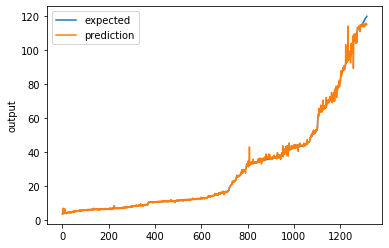

In [77]:
chart_regression(cnn_model_pred.flatten(),y_test_for_cnn)

## CNN with 'tanh' as activation function and 'adam' as optimizer with variation in kernel number and kernel size

In [169]:
cnn_model = Sequential()
cnn_model.add(Conv2D(16, kernel_size=(5, 5), strides=(2, 2),activation='tanh',input_shape=(1,7,5),padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(1, 5),padding='same'))
cnn_model.add(Conv2D(32, kernel_size=(5, 5), strides=(2, 2),activation='tanh',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(1, 5),padding='same'))
cnn_model.add(Conv2D(64,kernel_size=(5, 5), strides=(2, 2),activation='tanh',padding='same'))
cnn_model.add(MaxPooling2D(pool_size=(1, 5),padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dense(500, activation='tanh'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(1))
cnn_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 1, 4, 16)          2016      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 1, 1, 16)          0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 1, 32)          12832     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 1, 64)          51264     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)              

In [170]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_cnn_4.hdf5', verbose=0, save_best_only=True) # save best model
   
cnn_model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')
cnn_model.fit(x_train_for_cnn, y_train_for_cnn,batch_size=64,validation_data=(x_test_for_cnn,y_test_for_cnn),callbacks=[monitor,checkpointer],verbose=2,epochs=1000)

Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 14s - loss: 1174.3307 - val_loss: 354.2807
Epoch 2/1000
3068/3068 - 2s - loss: 266.4849 - val_loss: 186.9404
Epoch 3/1000
3068/3068 - 2s - loss: 153.4614 - val_loss: 110.3284
Epoch 4/1000
3068/3068 - 2s - loss: 91.7141 - val_loss: 66.2325
Epoch 5/1000
3068/3068 - 2s - loss: 58.2383 - val_loss: 44.3502
Epoch 6/1000
3068/3068 - 2s - loss: 41.3689 - val_loss: 32.2295
Epoch 7/1000
3068/3068 - 2s - loss: 30.3726 - val_loss: 24.8618
Epoch 8/1000
3068/3068 - 3s - loss: 24.0268 - val_loss: 17.5527
Epoch 9/1000
3068/3068 - 2s - loss: 17.6586 - val_loss: 14.1163
Epoch 10/1000
3068/3068 - 2s - loss: 12.6365 - val_loss: 10.1421
Epoch 11/1000
3068/3068 - 2s - loss: 10.9907 - val_loss: 9.3471
Epoch 12/1000
3068/3068 - 2s - loss: 10.0351 - val_loss: 6.5314
Epoch 13/1000
3068/3068 - 2s - loss: 7.3541 - val_loss: 5.9181
Epoch 14/1000
3068/3068 - 2s - loss: 6.9147 - val_loss: 5.9860
Epoch 15/1000
3068/3068 - 2s - loss: 6.8359 - val

In [171]:
from sklearn import metrics

cnn_model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_cnn_4.hdf5')

cnn_model_pred = cnn_model.predict(x_test_for_cnn)

score3 = np.sqrt(metrics.mean_squared_error(y_test_for_cnn,cnn_model_pred)) 

print("RMSE: {}".format(score3))

RMSE: 1.5852685907969761


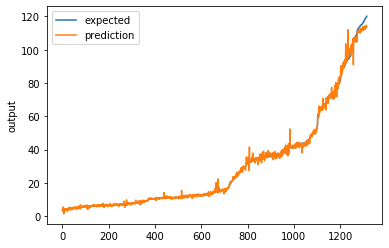

In [172]:
chart_regression(cnn_model_pred.flatten(),y_test_for_cnn)

In [173]:
print("RMSE SCORE:")
print("1)Activation-relu, Opt-adam:        {}".format(score))
print("2)Activation-sigmoid, Opt-adam:     {}".format(score1))
print("3)Activation-tanh, Opt-adam:        {}".format(score2))
print("4)Activation-tanh, Opt-adam, varied kernel size, number of layers and number of neurons in each layer: {}".format(score3))

RMSE SCORE:
1)Activation-relu, Opt-adam:        1.0869901464668226
2)Activation-sigmoid, Opt-adam:     29.612789825440313
3)Activation-tanh, Opt-adam:        1.2729040918908356
4)Activation-tanh, Opt-adam, varied kernel size, number of layers and number of neurons in each layer: 1.5852685907969761


In [83]:
print("Best CNN model is with Activtion- tanh  Opt- adam and has RMSE score: {}".format(score2) )

Best CNN model is with Activtion- tanh  Opt- adam and has RMSE score: 1.2729040918908356


# Additional Features

## 1) Varying the past number of days i.e. N=5

In [84]:
#Preparing x and y to process time-series data
SEQUENCE_SIZE = 5
x,y = to_sequences(SEQUENCE_SIZE, data.values, data_close)

print("Shape of x: {}".format(x.shape))
print("Shape of y: {}".format(y.shape))

Shape of x: (4386, 5, 5)
Shape of y: (4386,)


In [85]:
#Splitting the data into training and test data for LSTM model where each record can be viewed as a sequence of 7 vectors, each vector with 5 dimensions. 
x_train_for_lstm_additional,x_test_for_lstm_additional,y_train_for_lstm_additional,y_test_for_lstm_additional = train_test_split(x,y, test_size=0.3, random_state =0)
print("Shape of x_train: {}".format(x_train_for_lstm_additional.shape))
print("Shape of x_test: {}".format(x_test_for_lstm_additional.shape))
print("Shape of y_train: {}".format(y_train_for_lstm_additional.shape))
print("Shape of y_test: {}".format(y_test_for_lstm_additional.shape))

Shape of x_train: (3070, 5, 5)
Shape of x_test: (1316, 5, 5)
Shape of y_train: (3070,)
Shape of y_test: (1316,)


In [86]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_sigmoid_sgd_additional1.hdf5', verbose=0, save_best_only=True) # save best model    
print('Build model...')
model = Sequential()
model.add(LSTM(68, activation='sigmoid',dropout=0.0, recurrent_dropout=0.0,input_shape=(5, 5)))
model.add(Dense(34 , activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train_for_lstm_additional,y_train_for_lstm_additional,validation_data=(x_test_for_lstm_additional,y_test_for_lstm_additional),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 

Build model...
Train...
Train on 3070 samples, validate on 1316 samples
Epoch 1/1000
3070/3070 - 10s - loss: 216.1623 - val_loss: 15.8735
Epoch 2/1000
3070/3070 - 3s - loss: 19.1220 - val_loss: 5.5691
Epoch 3/1000
3070/3070 - 4s - loss: 4.4836 - val_loss: 2.6193
Epoch 4/1000
3070/3070 - 3s - loss: 3.5912 - val_loss: 2.4260
Epoch 5/1000
3070/3070 - 2s - loss: 3.0772 - val_loss: 2.0025
Epoch 6/1000
3070/3070 - 3s - loss: 2.6227 - val_loss: 1.8804
Epoch 7/1000
3070/3070 - 4s - loss: 1.6592 - val_loss: 2.6177
Epoch 8/1000
3070/3070 - 4s - loss: 2.1174 - val_loss: 1.5168
Epoch 9/1000
3070/3070 - 4s - loss: 1.6487 - val_loss: 1.6722
Epoch 10/1000
3070/3070 - 4s - loss: 1.6363 - val_loss: 2.2059
Epoch 11/1000
3070/3070 - 4s - loss: 1.5946 - val_loss: 1.4072
Epoch 12/1000
3070/3070 - 4s - loss: 1.4958 - val_loss: 1.3720
Epoch 13/1000
3070/3070 - 4s - loss: 1.4204 - val_loss: 1.4893
Epoch 14/1000
3070/3070 - 4s - loss: 1.4228 - val_loss: 1.9132
Epoch 15/1000
3070/3070 - 4s - loss: 1.1814 - val_

In [87]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_sigmoid_sgd_additional1.hdf5')
lstm_pred = model.predict(x_test_for_lstm_additional)

score_additional = np.sqrt(metrics.mean_squared_error(y_test_for_lstm_additional,lstm_pred)) 

print("RMSE: {}".format(score_additional))

RMSE: 1.1713265380683366


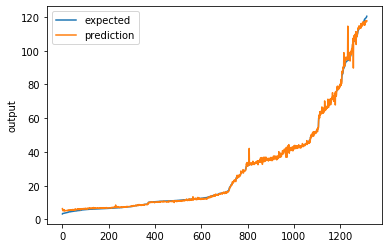

In [88]:
chart_regression(lstm_pred.flatten(),y_test_for_lstm_additional)

## N=10

In [89]:
#Preparing x and y to process time-series data
SEQUENCE_SIZE = 10
x,y = to_sequences(SEQUENCE_SIZE, data.values, data_close)

print("Shape of x: {}".format(x.shape))
print("Shape of y: {}".format(y.shape))

Shape of x: (4381, 10, 5)
Shape of y: (4381,)


In [90]:
#Splitting the data into training and test data for LSTM model where each record can be viewed as a sequence of 7 vectors, each vector with 5 dimensions. 
x_train_for_lstm_additional_1,x_test_for_lstm_additional_1,y_train_for_lstm_additional_1,y_test_for_lstm_additional_1 = train_test_split(x,y, test_size=0.3, random_state =0)
print("Shape of x_train: {}".format(x_train_for_lstm_additional_1.shape))
print("Shape of x_test: {}".format(x_test_for_lstm_additional_1.shape))
print("Shape of y_train: {}".format(y_train_for_lstm_additional_1.shape))
print("Shape of y_test: {}".format(y_test_for_lstm_additional_1.shape))

Shape of x_train: (3066, 10, 5)
Shape of x_test: (1315, 10, 5)
Shape of y_train: (3066,)
Shape of y_test: (1315,)


In [91]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_sigmoid_sgd_additional2.hdf5', verbose=0, save_best_only=True) # save best model    
print('Build model...')
model = Sequential()
model.add(LSTM(68, activation='sigmoid',dropout=0.0, recurrent_dropout=0.0,input_shape=(10, 5)))
model.add(Dense(34 , activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train_for_lstm_additional_1,y_train_for_lstm_additional_1,validation_data=(x_test_for_lstm_additional_1,y_test_for_lstm_additional_1),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 

Build model...
Train...
Train on 3066 samples, validate on 1315 samples
Epoch 1/1000
3066/3066 - 11s - loss: 185.1724 - val_loss: 68.8653
Epoch 2/1000
3066/3066 - 7s - loss: 14.1988 - val_loss: 20.5463
Epoch 3/1000
3066/3066 - 10s - loss: 8.4078 - val_loss: 2.5291
Epoch 4/1000
3066/3066 - 6s - loss: 3.7006 - val_loss: 3.7045
Epoch 5/1000
3066/3066 - 5s - loss: 5.9876 - val_loss: 1.5419
Epoch 6/1000
3066/3066 - 5s - loss: 2.0109 - val_loss: 3.7089
Epoch 7/1000
3066/3066 - 5s - loss: 2.1313 - val_loss: 3.0802
Epoch 8/1000
3066/3066 - 5s - loss: 3.2617 - val_loss: 1.2051
Epoch 9/1000
3066/3066 - 5s - loss: 1.7784 - val_loss: 2.4276
Epoch 10/1000
3066/3066 - 5s - loss: 1.6380 - val_loss: 2.2459
Epoch 11/1000
3066/3066 - 5s - loss: 1.3901 - val_loss: 1.5165
Epoch 12/1000
3066/3066 - 5s - loss: 1.3510 - val_loss: 1.0347
Epoch 13/1000
3066/3066 - 6s - loss: 1.4148 - val_loss: 0.9712
Epoch 14/1000
3066/3066 - 7s - loss: 2.2128 - val_loss: 1.1016
Epoch 15/1000
3066/3066 - 7s - loss: 1.4415 - va

In [92]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_sigmoid_sgd_additional2.hdf5')
lstm_pred = model.predict(x_test_for_lstm_additional_1)

score_additional1 = np.sqrt(metrics.mean_squared_error(y_test_for_lstm_additional_1,lstm_pred)) 

print("RMSE: {}".format(score_additional1))

RMSE: 0.8595142297127963


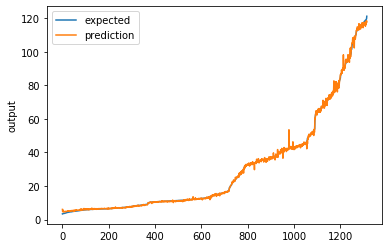

In [93]:
chart_regression(lstm_pred.flatten(),y_test_for_lstm_additional_1)

## N=25

In [94]:
#Preparing x and y to process time-series data
SEQUENCE_SIZE = 25
x,y = to_sequences(SEQUENCE_SIZE, data.values, data_close)

print("Shape of x: {}".format(x.shape))
print("Shape of y: {}".format(y.shape))

Shape of x: (4366, 25, 5)
Shape of y: (4366,)


In [95]:
#Splitting the data into training and test data for LSTM model where each record can be viewed as a sequence of 7 vectors, each vector with 5 dimensions. 
x_train_for_lstm_additional_2,x_test_for_lstm_additional_2,y_train_for_lstm_additional_2,y_test_for_lstm_additional_2 = train_test_split(x,y, test_size=0.3, random_state =0)
print("Shape of x_train: {}".format(x_train_for_lstm_additional_2.shape))
print("Shape of x_test: {}".format(x_test_for_lstm_additional_2.shape))
print("Shape of y_train: {}".format(y_train_for_lstm_additional_2.shape))
print("Shape of y_test: {}".format(y_test_for_lstm_additional_2.shape))

Shape of x_train: (3056, 25, 5)
Shape of x_test: (1310, 25, 5)
Shape of y_train: (3056,)
Shape of y_test: (1310,)


In [96]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_sigmoid_sgd_additional3.hdf5', verbose=0, save_best_only=True) # save best model    
print('Build model...')
model = Sequential()
model.add(LSTM(68, activation='sigmoid',dropout=0.0, recurrent_dropout=0.0,input_shape=(25, 5)))
model.add(Dense(34 , activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train_for_lstm_additional_2,y_train_for_lstm_additional_2,validation_data=(x_test_for_lstm_additional_2,y_test_for_lstm_additional_2),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 

Build model...
Train...
Train on 3056 samples, validate on 1310 samples
Epoch 1/1000
3056/3056 - 21s - loss: 192.3730 - val_loss: 7.2079
Epoch 2/1000
3056/3056 - 14s - loss: 17.6481 - val_loss: 3.7559
Epoch 3/1000
3056/3056 - 14s - loss: 6.0194 - val_loss: 3.3622
Epoch 4/1000
3056/3056 - 17s - loss: 2.8240 - val_loss: 3.0205
Epoch 5/1000
3056/3056 - 15s - loss: 4.5538 - val_loss: 5.9629
Epoch 6/1000
3056/3056 - 14s - loss: 2.5688 - val_loss: 8.9622
Epoch 7/1000
3056/3056 - 13s - loss: 2.1185 - val_loss: 1.8737
Epoch 8/1000
3056/3056 - 15s - loss: 1.7359 - val_loss: 1.2631
Epoch 9/1000
3056/3056 - 14s - loss: 2.0333 - val_loss: 1.6361
Epoch 10/1000
3056/3056 - 13s - loss: 1.9778 - val_loss: 1.0712
Epoch 11/1000
3056/3056 - 13s - loss: 1.6270 - val_loss: 2.0327
Epoch 12/1000
3056/3056 - 13s - loss: 1.3491 - val_loss: 1.5327
Epoch 13/1000
3056/3056 - 13s - loss: 1.7285 - val_loss: 1.2004
Epoch 14/1000
3056/3056 - 14s - loss: 1.3647 - val_loss: 3.8140
Epoch 15/1000
3056/3056 - 13s - loss: 

In [97]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_sigmoid_sgd_additional3.hdf5')
lstm_pred = model.predict(x_test_for_lstm_additional_2)

score_additional2 = np.sqrt(metrics.mean_squared_error(y_test_for_lstm_additional_2,lstm_pred)) 

print("RMSE: {}".format(score_additional2))

RMSE: 1.0350118367251353


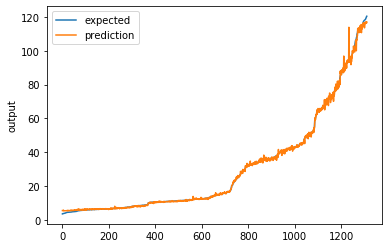

In [98]:
chart_regression(lstm_pred.flatten(),y_test_for_lstm_additional_2)

## 2) Yahoo! Finance - Finding the stock price using historical data of Google

In [134]:
#Read the file
import pandas as pd
df = pd.read_csv(r'C:\Users\16696\Desktop\AI_Project2\GOOG.csv')

In [135]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-04,1146.989990,1158.280029,1130.689941,1147.800049,1147.800049,1446000
1,2019-03-05,1150.060059,1169.609985,1146.194946,1162.030029,1162.030029,1443200
2,2019-03-06,1162.489990,1167.566040,1155.489990,1157.859985,1157.859985,1099300
3,2019-03-07,1155.719971,1156.755005,1134.910034,1143.300049,1143.300049,1166600
4,2019-03-08,1126.729980,1147.079956,1123.300049,1142.319946,1142.319946,1212400
...,...,...,...,...,...,...,...
247,2020-02-25,1433.000000,1438.140015,1382.400024,1388.449951,1388.449951,2478300
248,2020-02-26,1396.140015,1415.699951,1379.000000,1393.180054,1393.180054,2202400
249,2020-02-27,1362.060059,1371.703979,1317.170044,1318.089966,1318.089966,2978300
250,2020-02-28,1277.500000,1341.140015,1271.000000,1339.329956,1339.329956,3789100


In [136]:
#Drop 'Date' and 'Adj_Close' columns as they are not needed for prediction
df.drop(['Date','Adj Close'] , axis=1,inplace=True)

In [137]:
df

,Open,High,Low,Close,Volume
0,1146.989990,1158.280029,1130.689941,1147.800049,1446000
1,1150.060059,1169.609985,1146.194946,1162.030029,1443200
2,1162.489990,1167.566040,1155.489990,1157.859985,1099300
3,1155.719971,1156.755005,1134.910034,1143.300049,1166600
4,1126.729980,1147.079956,1123.300049,1142.319946,1212400
...,...,...,...,...,...
247,1433.000000,1438.140015,1382.400024,1388.449951,2478300
248,1396.140015,1415.699951,1379.000000,1393.180054,2202400
249,1362.060059,1371.703979,1317.170044,1318.089966,2978300
250,1277.500000,1341.140015,1271.000000,1339.329956,3789100


In [138]:
#Check for null values
print(df.isnull().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [139]:
#Select the target feature and convert it to list
df_close = df['Close'].tolist()

In [140]:
df_close

[1147.800049,
 1162.030029,
 1157.859985,
 1143.300049,
 1142.319946,
 1175.76001,
 1193.199951,
 1193.319946,
 1185.550049,
 1184.459961,
 1184.26001,
 1198.849976,
 1223.969971,
 1231.540039,
 1205.5,
 1193.0,
 1184.619995,
 1173.02002,
 1168.48999,
 1173.310059,
 1194.430054,
 1200.48999,
 1205.920044,
 1215.0,
 1207.150024,
 1203.839966,
 1197.25,
 1202.160034,
 1204.619995,
 1217.869995,
 1221.099976,
 1227.130005,
 1236.339966,
 1236.369995,
 1248.839966,
 1264.550049,
 1256.0,
 1263.449951,
 1272.180054,
 1287.579956,
 1188.47998,
 1168.079956,
 1162.609985,
 1185.400024,
 1189.390015,
 1174.099976,
 1166.27002,
 1162.380005,
 1164.27002,
 1132.030029,
 1120.439941,
 1164.209961,
 1178.97998,
 1162.300049,
 1138.849976,
 1149.630005,
 1151.420044,
 1140.77002,
 1133.469971,
 1134.150024,
 1116.459961,
 1117.949951,
 1103.630005,
 1036.22998,
 1053.050049,
 1042.219971,
 1044.339966,
 1066.040039,
 1080.380005,
 1078.719971,
 1077.030029,
 1088.77002,
 1085.349976,
 1092.5,
 1103

In [141]:
#Feature normalization using z-score normalization 
encode_numeric_zscore(df,"Open")
encode_numeric_zscore(df,"Low")
encode_numeric_zscore(df,"High")
encode_numeric_zscore(df,"Volume")
encode_numeric_zscore(df,"Close")

In [142]:
df

,Open,High,Low,Close,Volume
0,-0.853995,-0.839121,-0.921030,-0.855341,-0.024124
1,-0.827130,-0.740824,-0.785062,-0.731550,-0.028294
2,-0.718363,-0.758557,-0.703550,-0.767827,-0.540407
3,-0.777604,-0.852352,-0.884023,-0.894489,-0.440189
4,-1.031279,-0.936291,-0.985835,-0.903015,-0.371986
...,...,...,...,...,...
247,1.648719,1.588896,1.286299,1.238158,1.513109
248,1.326178,1.394210,1.256483,1.279307,1.102257
249,1.027963,1.012509,0.714275,0.626071,2.257677
250,0.288026,0.747341,0.309395,0.810846,3.465067


In [143]:
#Preparing x and y to process time-series data
SEQUENCE_SIZE = 7
x,y = to_sequences(SEQUENCE_SIZE, df.values, df_close)

print("Shape of x: {}".format(x.shape))
print("Shape of y: {}".format(y.shape))

Shape of x: (244, 7, 5)
Shape of y: (244,)


In [144]:
#Splitting the data into training and test data for LSTM model where each record can be viewed as a sequence of 7 vectors, each vector with 5 dimensions. 
x_train_for_lstm,x_test_for_lstm,y_train_for_lstm,y_test_for_lstm = train_test_split(x,y, test_size=0.3, random_state =0)
print("Shape of x_train: {}".format(x_train_for_lstm.shape))
print("Shape of x_test: {}".format(x_test_for_lstm.shape))
print("Shape of y_train: {}".format(y_train_for_lstm.shape))
print("Shape of y_test: {}".format(y_test_for_lstm.shape))

Shape of x_train: (170, 7, 5)
Shape of x_test: (74, 7, 5)
Shape of y_train: (170,)
Shape of y_test: (74,)


In [145]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_sigmoid_sgd_yahoo.hdf5', verbose=0, save_best_only=True) # save best model    
print('Build model...')
model = Sequential()
model.add(LSTM(68,dropout=0.1, recurrent_dropout=0.1,input_shape=(7, 5)))
model.add(Dense(34))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train_for_lstm,y_train_for_lstm,validation_data=(x_test_for_lstm,y_test_for_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 

Build model...
Train...
Train on 170 samples, validate on 74 samples
Epoch 1/1000
170/170 - 9s - loss: 1565230.0912 - val_loss: 1582489.6622
Epoch 2/1000
170/170 - 0s - loss: 1564634.6088 - val_loss: 1581676.1791
Epoch 3/1000
170/170 - 0s - loss: 1563664.4706 - val_loss: 1580216.5642
Epoch 4/1000
170/170 - 0s - loss: 1561874.5544 - val_loss: 1577400.7230
Epoch 5/1000
170/170 - 0s - loss: 1558448.8368 - val_loss: 1572110.0473
Epoch 6/1000
170/170 - 0s - loss: 1552132.8603 - val_loss: 1563134.4291
Epoch 7/1000
170/170 - 0s - loss: 1541921.0882 - val_loss: 1549719.5068
Epoch 8/1000
170/170 - 0s - loss: 1526906.0250 - val_loss: 1530451.4764
Epoch 9/1000
170/170 - 0s - loss: 1505072.4500 - val_loss: 1503897.5000
Epoch 10/1000
170/170 - 0s - loss: 1475935.4118 - val_loss: 1471207.7264
Epoch 11/1000
170/170 - 0s - loss: 1442423.0456 - val_loss: 1437380.0777
Epoch 12/1000
170/170 - 1s - loss: 1411100.2103 - val_loss: 1410081.7905
Epoch 13/1000
170/170 - 0s - loss: 1385587.8382 - val_loss: 1386

Epoch 116/1000
170/170 - 0s - loss: 13508.6514 - val_loss: 14199.2943
Epoch 117/1000
170/170 - 0s - loss: 13448.1961 - val_loss: 14122.9041
Epoch 118/1000
170/170 - 0s - loss: 13395.1098 - val_loss: 14058.9239
Epoch 119/1000
170/170 - 0s - loss: 13353.2105 - val_loss: 13997.1653
Epoch 120/1000
170/170 - 0s - loss: 13316.5590 - val_loss: 13944.6618
Epoch 121/1000
170/170 - 0s - loss: 13283.1877 - val_loss: 13899.0708
Epoch 122/1000
170/170 - 0s - loss: 13248.8029 - val_loss: 13866.2651
Epoch 123/1000
170/170 - 0s - loss: 13235.3735 - val_loss: 13824.6820
Epoch 124/1000
170/170 - 0s - loss: 13204.7271 - val_loss: 13797.1300
Epoch 125/1000
170/170 - 0s - loss: 13192.7226 - val_loss: 13768.7768
Epoch 126/1000
170/170 - 1s - loss: 13182.3923 - val_loss: 13748.7887
Epoch 127/1000
170/170 - 1s - loss: 13165.8913 - val_loss: 13735.1928
Epoch 128/1000
170/170 - 0s - loss: 13160.5990 - val_loss: 13718.3181
Epoch 129/1000
170/170 - 1s - loss: 13155.2459 - val_loss: 13704.6349
Epoch 130/1000
170/1

Epoch 236/1000
170/170 - 0s - loss: 1143.1444 - val_loss: 971.9221
Epoch 237/1000
170/170 - 0s - loss: 1236.4392 - val_loss: 970.7321
Epoch 238/1000
170/170 - 0s - loss: 1092.4873 - val_loss: 951.6121
Epoch 239/1000
170/170 - 0s - loss: 1038.6049 - val_loss: 936.8903
Epoch 240/1000
170/170 - 0s - loss: 1164.1414 - val_loss: 940.9561
Epoch 241/1000
170/170 - 0s - loss: 1044.2556 - val_loss: 930.3753
Epoch 242/1000
170/170 - 0s - loss: 1164.7543 - val_loss: 910.4365
Epoch 243/1000
170/170 - 0s - loss: 1017.0928 - val_loss: 906.3443
Epoch 244/1000
170/170 - 0s - loss: 994.0637 - val_loss: 884.6711
Epoch 245/1000
170/170 - 1s - loss: 991.8603 - val_loss: 863.9484
Epoch 246/1000
170/170 - 1s - loss: 995.1654 - val_loss: 858.6616
Epoch 247/1000
170/170 - 1s - loss: 1105.0581 - val_loss: 848.4530
Epoch 248/1000
170/170 - 1s - loss: 1042.0893 - val_loss: 842.4017
Epoch 249/1000
170/170 - 0s - loss: 1001.9610 - val_loss: 826.9924
Epoch 250/1000
170/170 - 0s - loss: 1116.1520 - val_loss: 828.640

In [146]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_sigmoid_sgd_yahoo.hdf5')
lstm_pred = model.predict(x_test_for_lstm)

score = np.sqrt(metrics.mean_squared_error(y_test_for_lstm,lstm_pred)) 

print("RMSE: {}".format(score))

RMSE: 21.583638870039415


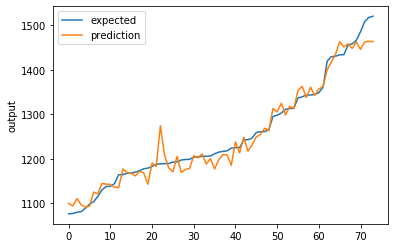

In [147]:
chart_regression(lstm_pred.flatten(),y_test_for_lstm)

## 3) Bidirectional LSTM 

In [148]:
#Read the file
import pandas as pd
data = pd.read_csv(r'C:\Users\16696\Desktop\AI_Project2\CSC215_P2_Stock_Price.csv')

In [149]:
data

,Date,Open,High,Low,Close,Adj_Close,Volume
0,3/27/2000,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,3/28/2000,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,3/29/2000,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,3/30/2000,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,3/31/2000,3.734375,3.734375,3.390625,3.390625,3.390625,7931600
...,...,...,...,...,...,...,...
4387,9/1/2017,113.790001,114.099998,112.790001,113.309998,113.309998,950000
4388,9/5/2017,112.519997,113.529999,111.160004,111.870003,111.870003,1805200
4389,9/6/2017,112.029999,112.489998,110.250000,112.230003,112.230003,2136700
4390,9/7/2017,112.459999,112.900002,112.000000,112.339996,112.339996,1251600


In [150]:
#Drop 'Date' and 'Adj_Close' columns as they are not needed for prediction
data.drop(['Date','Adj_Close'] , axis=1,inplace=True)

In [151]:
#Select the target feature and convert it to list
data_close = data['Close'].tolist()

In [152]:
#Feature normalization using z-score normalization 
encode_numeric_zscore(data,"Open")
encode_numeric_zscore(data,"Low")
encode_numeric_zscore(data,"High")
encode_numeric_zscore(data,"Volume")
encode_numeric_zscore(data,"Close")

In [153]:
data

,Open,High,Low,Close,Volume
0,-0.894209,-0.885022,-0.892306,-0.884364,1.104812
1,-0.883762,-0.886056,-0.885975,-0.888021,-0.497301
2,-0.887941,-0.889159,-0.887558,-0.888543,-0.892217
3,-0.887941,-0.890194,-0.891251,-0.893768,-0.000263
4,-0.896820,-0.898986,-0.906551,-0.908920,3.729366
...,...,...,...,...,...
4387,2.782154,2.754177,2.787407,2.766603,-0.575988
4388,2.739700,2.735310,2.732368,2.718452,-0.048610
4389,2.723320,2.700885,2.701641,2.730490,0.155816
4390,2.737694,2.714457,2.760732,2.734168,-0.390000


In [154]:
#Preparing x and y to process time-series data
SEQUENCE_SIZE = 7
x,y = to_sequences(SEQUENCE_SIZE, data.values, data_close)

print("Shape of x: {}".format(x.shape))
print("Shape of y: {}".format(y.shape))

Shape of x: (4384, 7, 5)
Shape of y: (4384,)


In [155]:
#Splitting the data into training and test data for LSTM model where each record can be viewed as a sequence of 7 vectors, each vector with 5 dimensions. 
x_train_for_lstm_additional,x_test_for_lstm_additional,y_train_for_lstm_additional,y_test_for_lstm_additional = train_test_split(x,y, test_size=0.3, random_state =0)
print("Shape of x_train: {}".format(x_train_for_lstm_additional.shape))
print("Shape of x_test: {}".format(x_test_for_lstm_additional.shape))
print("Shape of y_train: {}".format(y_train_for_lstm_additional.shape))
print("Shape of y_test: {}".format(y_test_for_lstm_additional.shape))

Shape of x_train: (3068, 7, 5)
Shape of x_test: (1316, 7, 5)
Shape of y_train: (3068,)
Shape of y_test: (1316,)


In [156]:
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import TimeDistributed


In [157]:
checkpointer = ModelCheckpoint(filepath=r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_sigmoid_sgd_additional_bi.hdf5', verbose=0, save_best_only=True) # save best model    
print('Build model...')
model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True,input_shape=(7, 5))))

model.add(Bidirectional(LSTM(10)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')
model.fit(x_train_for_lstm_additional,y_train_for_lstm_additional,validation_data=(x_test_for_lstm_additional,y_test_for_lstm_additional),callbacks=[monitor,checkpointer],verbose=2, epochs=1000) 

Build model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train...
Train on 3068 samples, validate on 1316 samples
Epoch 1/1000
3068/3068 - 21s - loss: 1736.0744 - val_loss: 1519.7189
Epoch 2/1000
3068/3068 - 6s - loss: 1439.9987 - val_loss: 1285.4566
Epoch 3/1000
3068/3068 - 6s - loss: 1288.1722 - val_loss: 1192.1706
Epoch 4/1000
3068/3068 - 6s - loss: 1200.1993 - val_loss: 1111.0736
Epoch 5/1000
3068/3068 - 6s - loss: 1120.9500 - val_loss: 1038.1155
Epoch 6/1000
3068/3068 - 6s - loss: 1050.4248 - val_loss: 972.6473
Epoch 7/1000
3068/3068 - 6s - loss: 986.9361 - val_loss: 914.3545
Epoch 8/1000
3068/3068 - 6s - loss: 928.4786 - val_loss: 860.4871
Epoch 9/1000
3068/3068 - 6s - loss

Epoch 109/1000
3068/3068 - 7s - loss: 1.0714 - val_loss: 1.3449
Epoch 110/1000
3068/3068 - 6s - loss: 0.9767 - val_loss: 1.3368
Epoch 111/1000
3068/3068 - 7s - loss: 0.9664 - val_loss: 1.2645
Epoch 112/1000
3068/3068 - 6s - loss: 0.9896 - val_loss: 1.5613
Epoch 113/1000
3068/3068 - 6s - loss: 0.9241 - val_loss: 1.5286
Epoch 114/1000
3068/3068 - 7s - loss: 0.8882 - val_loss: 1.3176
Epoch 115/1000
3068/3068 - 6s - loss: 0.8685 - val_loss: 1.2097
Epoch 116/1000
3068/3068 - 7s - loss: 0.8576 - val_loss: 1.1815
Epoch 117/1000
3068/3068 - 7s - loss: 0.8616 - val_loss: 1.2213
Epoch 118/1000
3068/3068 - 7s - loss: 0.7635 - val_loss: 1.2752
Epoch 119/1000
3068/3068 - 6s - loss: 0.8098 - val_loss: 1.2179
Epoch 120/1000
3068/3068 - 7s - loss: 0.7945 - val_loss: 1.3379
Epoch 121/1000
3068/3068 - 7s - loss: 0.7960 - val_loss: 1.1980
Epoch 00121: early stopping


In [159]:
from sklearn import metrics
from sklearn.metrics import r2_score

model.load_weights(r'C:\Users\16696\Desktop\AI_Project2\best_weights_lstm_sigmoid_sgd_additional_bi.hdf5')
lstm_pred = model.predict(x_test_for_lstm_additional)

score = np.sqrt(metrics.mean_squared_error(y_test_for_lstm_additional,lstm_pred)) 

print("RMSE : {}".format(score))

RMSE : 1.0869901464668226


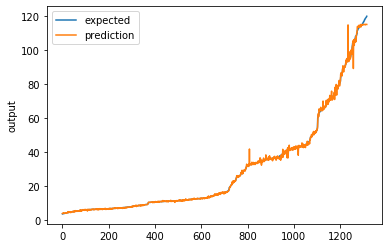

In [160]:
chart_regression(lstm_pred.flatten(),y_test_for_lstm_additional)